In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from skimage.transform import resize, pyramid_reduce

In [2]:
def plot(images):
    s = 5
    n = len(images)
    fig, ax = plt.subplots(1,n,figsize=(s*n,s))
    if n==1: 
        ax = imshow(ax,images[-1])
    else:
        for i, im in enumerate(images):
            ax[i] = imshow(ax[i],im)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    plt.show()
    
def plotpoints(image,points,idx=None):
    s = 5
    fig, ax = plt.subplots(1,1,figsize=(s,s))
    ax = imshow(ax,image)
    ax.scatter(*points,c='r',s=5)
    if idx:
        for ix in idx:
            d = 2
            ax.scatter(points[0][ix:ix+1],points[1][ix:ix+1],marker='x',c='g',s=40)
            ax.annotate(str(ix), (points[0][ix]+d, points[1][ix]+d), color='green', fontsize=20)
    else:
        d = 0.2
        txt = np.arange(0,len(points[0])).astype(str)
        for i, t in enumerate(txt):
            ax.annotate(t, (points[0][i]+d, points[1][i]+d), color='red')
    plt.show()

def imshow(ax,im):
    ax.imshow(im,cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def get_square(image, square_size):

    height, width = image.shape
    if(height > width):
        differ = height
    else:
        differ = width
    differ += 4

    # square filler
    mask = np.zeros((differ, differ), dtype = "uint8")

    x_pos = int((differ - width) / 2)
    y_pos = int((differ - height) / 2)

    # center image inside the square
    mask[y_pos: y_pos + height, x_pos: x_pos + width] = image[0: height, 0: width]

    # downscale if needed
    if differ / square_size > 1:
        mask = pyramid_reduce(mask, differ / square_size)
    else:
        mask = resize(mask, (square_size, square_size))
        #mask = cv2.resize(mask, (square_size, square_size), interpolation = cv2.INTER_AREA)
    return mask

(1, 300, 400)


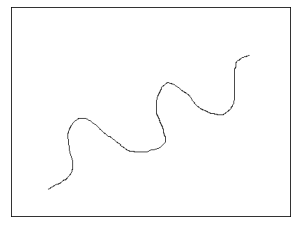

In [71]:
img = cv2.imread('/home/rosi/atika-project/work/2023/iafpp-wp1.3-motion-planner/code/trajectory_planner_ws/src/task_planning/images/freehand.png',0)
output = cv2.connectedComponentsWithStatsWithAlgorithm(img,8,cv2.CV_16U,-1)
(numLabels, labels, stats, centroids) = output
tmp = np.zeros((numLabels-1,)+img.shape, dtype=np.uint8)
for l in range(1,numLabels):
    tmp[l-1][np.where(labels == l)] = 255
print(tmp.shape)
plot([t for t in tmp])

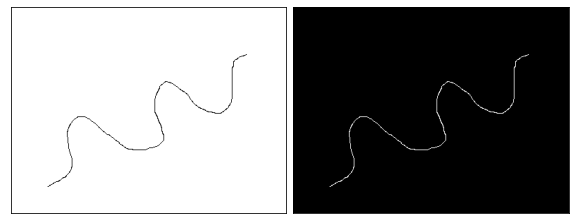

In [72]:
img = tmp[-1]
#blur = cv2.blur(img, (35, 35))
#thresh = cv2.threshold(blur, 250, 255, cv2.THRESH_BINARY_INV)[1]
thresh = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY_INV)[1]
plot([img,thresh])

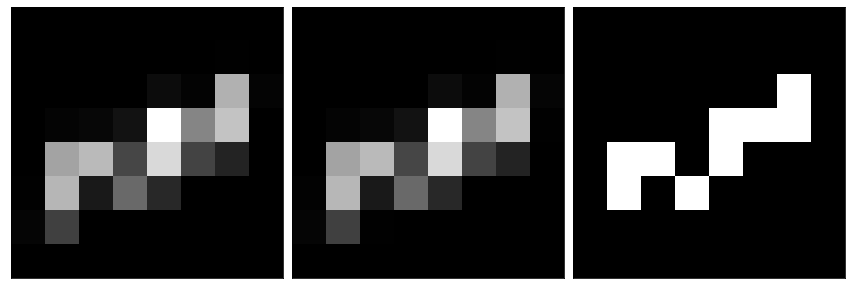

In [73]:
mask = get_square(thresh,8)
#mask = get_square(img,8)
norm = cv2.normalize(mask, None, alpha=255, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U).astype(np.uint8)
thresh2 = cv2.threshold(norm, 75, 255, cv2.THRESH_BINARY)[1]
#thin = cv2.ximgproc.thinning(thresh2, cv2.ximgproc.THINNING_ZHANGSUEN)
plot([mask,norm,thresh2])

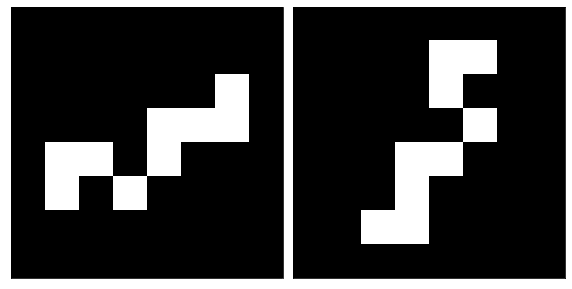

In [74]:
rot = cv2.rotate(thresh2, cv2.ROTATE_90_COUNTERCLOCKWISE)
#rot = cv2.rotate(thin, cv2.ROTATE_90_COUNTERCLOCKWISE)
flip = cv2.flip(rot, 0)
plot([thresh2,flip])

In [93]:
pts = np.where(flip>0)
n = 3
count = []
for idx,(px,py) in enumerate(zip(*pts)):
    assert flip[px,py] == 255
    temp_px = np.arange(max(px-n//2,0),min(px+n//2+1,flip.shape[1])) # width
    temp_py = np.arange(max(py-n//2,0),min(py+n//2+1,flip.shape[0])) # height
    grid_px, grid_py = np.meshgrid(temp_px, temp_py)
    list_px = grid_px.flatten()
    list_py = grid_py.flatten()
    #vals = np.array([1 if flip[i,j] else 0 for i,j in zip(list_px,list_py)]).reshape((n,n))
    vals = [flip[i,j] for i,j in zip(list_px,list_py)]
    #print('Index ',idx,'\n',vals,'\n---')
    grid = np.count_nonzero(vals)
    count.append(grid)
    print('Index:',idx,'\tPoint: ',px,' ',py,'\tCount:',count[idx])
    #if idx==8: print(np.array(vals).reshape(len(temp_py),len(temp_px)))
assert len(count) == len(pts[0])
print('---')
pt_start = np.argsort(count)[0]
pt_end = np.argsort(count)[1]
print('Start index:',pt_start,'\tCount:',count[pt_start])
print('End index:',pt_end,'\tCount:',count[pt_end])

Index: 0 	Point:  1   4 	Count: 3
Index: 1 	Point:  1   5 	Count: 3
Index: 2 	Point:  2   4 	Count: 4
Index: 3 	Point:  3   5 	Count: 3
Index: 4 	Point:  4   3 	Count: 3
Index: 5 	Point:  4   4 	Count: 4
Index: 6 	Point:  5   3 	Count: 5
Index: 7 	Point:  6   2 	Count: 3
Index: 8 	Point:  6   3 	Count: 3
---
Start index: 0 	Count: 3
End index: 1 	Count: 3


In [94]:
pt_end = np.argsort(count)[1]
ctn = 0
while (abs(pt_start-pt_end) == 1):
    pt_end = np.argsort(count)[ctn+2]
    ctn += 1
print('Start index:',pt_start,'\tCount:',count[pt_start])
print('End index:',pt_end,'\tCount:',count[pt_end])

Start index: 0 	Count: 3
End index: 3 	Count: 3


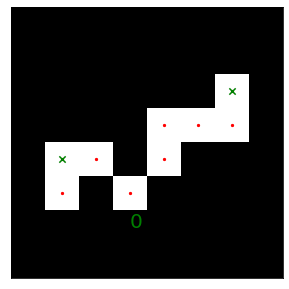

In [92]:
pts = np.where(flip>0)
pts = np.array(pts).T
N = len(pts)
plotpoints(thresh2,pts.T,[pt_start,pt_end])

In [88]:
class Node:

    def __init__(self, x, y):

        self.x = x 
        self.y = y
        self.f = 0
        self.g = 0
        self.h = 0
        self.neighbors = []
        self.previous = None
        self.obstacle = False

    def add_neighbors(self,grid, columns, rows):

        neighbor_x = self.x
        neighbor_y = self.y
    
        if neighbor_x < columns - 1:
            self.neighbors.append(grid[neighbor_x+1][neighbor_y])
        if neighbor_x > 0:
            self.neighbors.append(grid[neighbor_x-1][neighbor_y])
        if neighbor_y < rows -1:
            self.neighbors.append(grid[neighbor_x][neighbor_y +1])
        if neighbor_y > 0: 
            self.neighbors.append(grid[neighbor_x][neighbor_y-1])
        #diagonals
        if neighbor_x > 0 and neighbor_y > 0:
            self.neighbors.append(grid[neighbor_x-1][neighbor_y-1])
        if neighbor_x < columns -1 and neighbor_y > 0:
            self.neighbors.append(grid[neighbor_x+1][neighbor_y-1])
        if neighbor_x > 0 and neighbor_y <rows -1:
            self.neighbors.append(grid[neighbor_x-1][neighbor_y+1])
        if neighbor_x < columns -1 and neighbor_y < rows -1:
            self.neighbors.append(grid[neighbor_x+1][neighbor_y+1])


        
class Solver:

    def __init__(self, cols, rows, start, end, obstacle_list):

        self.cols = cols
        self.rows = rows
        self.start = start
        self.end = end
        self.obstacle_list = obstacle_list

    @staticmethod
    def clean_open_set(open_set, current_node):

        for i in range(len(open_set)):
            if open_set[i] == current_node:
                open_set.pop(i)
                break

        return open_set

    @staticmethod
    def h_score(current_node, end):

        distance =  abs(current_node.x - end.x) + abs(current_node.y - end.y)
        
        return distance

    @staticmethod
    def create_grid(cols, rows):

        grid = []
        for _ in range(cols):
            grid.append([])
            for _ in range(rows):
                grid[-1].append(0)
        
        return grid

    @staticmethod
    def fill_grids(grid, cols, rows, obstacle_list):

        for i in range(cols):
            for j in range(rows):
                grid[i][j] = Node(i,j)

        for i in range(len(obstacle_list)):
            grid[obstacle_list[i][0]][obstacle_list[i][1]].obstacle = True

        return grid

    @staticmethod
    def get_neighbors(grid, cols, rows):
        for i in range(cols):
            for j in range(rows):
                grid[i][j].add_neighbors(grid, cols, rows)
        return grid
    
    @staticmethod
    def start_path(open_set, closed_set, current_node, end):

        best_way = 0
        for i in range(len(open_set)):
            if open_set[i].f < open_set[best_way].f:
                best_way = i

        current_node = open_set[best_way]
        final_path = []
        if current_node == end:
            temp = current_node
            while temp.previous:
                final_path.append(temp.previous)
                temp = temp.previous
            
            print("Done !!")

        open_set = Solver.clean_open_set(open_set, current_node)
        closed_set.append(current_node)
        neighbors = current_node.neighbors
        for neighbor in neighbors:
            if (neighbor in closed_set) or (neighbor.obstacle == True):
                continue
            else:
                temp_g = current_node.g + 1
                control_flag = 0
                for k in range(len(open_set)):
                    if neighbor.x == open_set[k].x and neighbor.y == open_set[k].y:
                        if temp_g < open_set[k].g:
                            open_set[k].g = temp_g
                            open_set[k].h= AStar.h_score(open_set[k], end)
                            open_set[k].f = open_set[k].g + open_set[k].h
                            open_set[k].previous = current_node
                        else:
                            pass
                        control_flag = 1
  
                if control_flag == 1:
                    pass
                else:
                    neighbor.g = temp_g
                    neighbor.h = Solver.h_score(neighbor, end)
                    neighbor.f = neighbor.g + neighbor.h
                    neighbor.previous = current_node
                    open_set.append(neighbor)

        return open_set, closed_set, current_node, final_path

    def solve(self):
        grid = Solver.create_grid(self.cols, self.rows)
        grid = Solver.fill_grids(grid, self.cols, self.rows, self.obstacle_list)
        grid = Solver.get_neighbors(grid, self.cols, self.rows)
        open_set  = []
        closed_set  = []
        current_node = None
        final_path  = []
        open_set.append(grid[self.start[0]][self.start[1]])
        self.end = grid[self.end[0]][self.end[1]]
        while len(open_set) > 0:
            open_set, closed_set, current_node, final_path = Solver.start_path(open_set, closed_set, current_node, self.end)
            if len(final_path) > 0:
                break

        return final_path

In [89]:
data = np.argwhere(flip == 0)

cols = flip.shape[0]
rows = flip.shape[1]

start_x, start_y = pts[pt_start]
end_x, end_y = pts[pt_end]

a_star = Solver(cols, rows, [start_x, start_y], [end_x, end_y], data)

final_path = a_star.solve()

Done !!


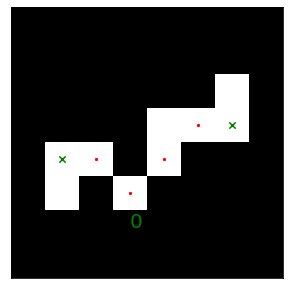

In [90]:
new_pts = np.array([[p.x, p.y] for p in final_path[::-1]])
new_pts = np.append(new_pts,[pts[pt_end]],axis=0)
plotpoints(thresh2,new_pts.T,[0,len(new_pts)-1])

In [626]:
# Python program for Dijkstra's single
# source shortest path algorithm. The program is
# for adjacency matrix representation of the graph
 
# Library for INT_MAX
import sys
 
class Graph():
 
    def __init__(self, vertices):
        self.V = vertices
        self.graph = [[0 for column in range(vertices)]
                      for row in range(vertices)]
 
    # A utility function to find the vertex with
    # minimum distance value, from the set of vertices
    # not yet included in shortest path tree
    def minDistance(self, dist, sptSet):
 
        # Initialize minimum distance for next node
        min = sys.maxsize
 
        # Search not nearest vertex not in the
        # shortest path tree
        for u in range(self.V):
            if dist[u] < min and sptSet[u] == False:
                min = dist[u]
                min_index = u
 
        return min_index
 
    # Function that implements Dijkstra's single source
    # shortest path algorithm for a graph represented
    # using adjacency matrix representation
    def dijkstra(self, src):
 
        path = [0] * self.V
        dist = [sys.maxsize] * self.V
        dist[src] = 0
        sptSet = [False] * self.V
 
        for cout in range(self.V):
 
            # Pick the minimum distance vertex from
            # the set of vertices not yet processed.
            # x is always equal to src in first iteration
            x = self.minDistance(dist, sptSet)
 
            # Put the minimum distance vertex in the
            # shortest path tree
            sptSet[x] = True
            path[cout] = x
 
            # Update dist value of the adjacent vertices
            # of the picked vertex only if the current
            # distance is greater than new distance and
            # the vertex in not in the shortest path tree
            for y in range(self.V):
                if self.graph[x][y] > 0 and sptSet[y] == False and \
                        dist[y] > dist[x] + self.graph[x][y]:
                    dist[y] = dist[x] + self.graph[x][y]
 
        return path

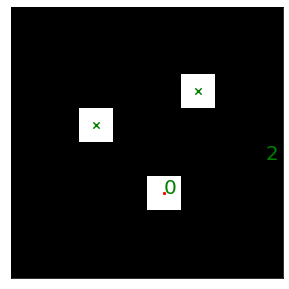

In [628]:
n = len(pts)
adj = [np.linalg.norm(pts-p,axis=1).tolist() for p in pts]
    
g = Graph(n)
g.graph = adj
path = g.dijkstra(pt_start)

new_pts = pts[path]
plotpoints(thin,new_pts.T,[0,len(new_pts)-1])
#plotpoints(thin,new_pts.T,[0,8])

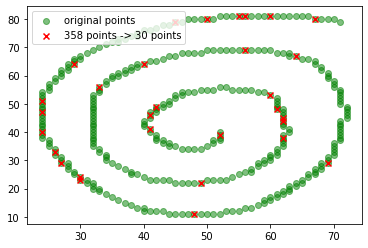

In [360]:
data = np.copy(pts)
# Compute KDE
kde = stats.gaussian_kde(data.T)
# Choice probabilities are computed from inverse probability density in KDE
p = 1 / kde.pdf(data.T)
# Normalize choice probabilities
p /= np.sum(p)
# Make sample using choice probabilities
idx = np.random.choice(np.arange(len(data)), size=30, replace=False, p=p)
sample = data[idx]

plt.scatter(*pts.T, marker='o', c='g', alpha=0.5, label="original points")
plt.scatter(*sample.T, marker='x', c='r', label="{} points -> {} points".format(len(data),len(sample)))
plt.legend()
plt.show()